### Working with FITS files

In [1]:
from astropy.io import fits

The *open()* function in [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html#) works with regular and compressed files.

Open a FITS file and look at the contents:

In [2]:
f = fits.open('j94f05bgq_flt.fits.gz')
f.info()
f.close()

Filename: j94f05bgq_flt.fits.gz
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     241   ()      
  1  SCI         ImageHDU       192   (1, 1)   float32   
  2  ERR         ImageHDU        69   ()      
  3  DQ          ImageHDU        69   ()      
  4  SCI         ImageHDU       184   (1, 1)   float32   
  5  ERR         ImageHDU        69   ()      
  6  DQ          ImageHDU        69   ()      


In [4]:
fits.info('j94f05bgq_flt.fits.gz')

Filename: j94f05bgq_flt.fits.gz
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     241   ()      
  1  SCI         ImageHDU       192   (1, 1)   float32   
  2  ERR         ImageHDU        69   ()      
  3  DQ          ImageHDU        69   ()      
  4  SCI         ImageHDU       184   (1, 1)   float32   
  5  ERR         ImageHDU        69   ()      
  6  DQ          ImageHDU        69   ()      


In [5]:
type(f)

astropy.io.fits.hdu.hdulist.HDUList

FITS file objects are like lists. Individual HDUs are indexed like lists.

In [6]:
f[1]

or using a (EXTNAME, EXTVER) tuple.

In [7]:
f[("SCI", 1)]

astropy v 1.3 implements lazy loading of FITS files. To turn the feature off pass *lazy_load_hdus=False* to read all
the HDUs into memory immediately upon opening the file.

In [8]:
f.info()

Filename: j94f05bgq_flt.fits.gz
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     241   ()      
  1  SCI         ImageHDU       192   (1, 1)   float32   
  2  ERR         ImageHDU        69   ()      
  3  DQ          ImageHDU        69   ()      
  4  SCI         ImageHDU       184   (1, 1)   float32   
  5  ERR         ImageHDU        69   ()      
  6  DQ          ImageHDU        69   ()      


that HDU was no read while the HDUList was open
is deprecated.  That is, you did something like:

    >>> hdulist.close()
    >>> print(hdulist[2].header)

even though hdulist[2] had not been read yet.  Instead
do:

    >>> print(hdulist[2].header)
    >>> hdulist.close()

or open the file with lazy_load_hdus=False to read all
the HDUs into memory immediately upon opening the file.
 [astropy.io.fits.hdu.hdulist]


### Working with headers

Headers are similar to python dictionaries.
Look at a header, modify an existing keyword and add a new card.

In [10]:
with fits.open('j94f05bgq_flt.fits.gz', mode='update') as f:
    # Updating a keyword
    print("crpix1: ", f[1].header['crpix1'])
    f[1].header['crpix1'] = 12
    print("Updated crpix1 :", f[1].header['crpix1'])
    

crpix1:  1024
Updated crpix1 : 12


Opening a FITS file using the Python *with* statement
ensures that the file is closed without explicitely doing so.

There are several ways to add a new card.

Note: Attempting to access a non-existing keyword raises a *KeyError*.

In [11]:
#print(f[1].header['observer'])
    

In [13]:
f[1].header['observer'] = "Edwin Hubble"
    
# Assigning a tuple to a keyword splits
# the tuple into a keyword value and comment.
    
f[1].header['NOBS'] = (2, "Number of observing nights")
print("observer:", f[1].header['observer'])
print(f[1].header.comments['NOBS'], f[1].header['NOBS'])

observer: Edwin Hubble
Number of observing nights 2


To delete a keyword/card use the python *del* operator.

Again a *KeyError* is raised if the keyword is not in the header.

In [14]:
    del f[1].header['NOBS']
    del f[1].header['observer']
    

Comment and history cards are added as regular keywords. In this case a new card is always created.

In [16]:
with fits.open('j94f05bgq_flt.fits.gz', mode='update') as f:
    f[1].header["history"] = "New history card."
    f[1].header["comment"] = "This is a 47 Tuc observation with HST"
    f[1].header["comment"] = "I'd like to observe it with JWST."
    f[1].header['comment']
    print(f[1].header['comment'])

This is a 47 Tuc observation with HST
I'd like to observe it with JWST.


### Working with image data

In [17]:
f = fits.open('pix.fits.gz')
f.info()

Filename: pix.fits.gz
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      53   (512, 512)   int16   


An image is a numpy array saved as the data part of an HDU.

In [18]:
scidata = f[0].data
print(scidata.shape)
print(scidata.dtype)

(512, 512)
>i2


*scidata* is a pointer to the data array of the HDU and if it changes, the data in the HDU changes as well.

In [20]:
# All operations available to NDArray are applicable to the fits data array.
scidata[2:10, 3:7].mean()

38.375

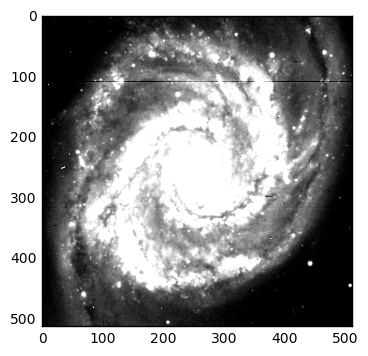

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(scidata, vmin=50, vmax=150, cmap='gray')

astropy.io.fits provides convenience functions to operate on 
fits files. These are good for interactive and quick lookup use.
It is recommended to use the OO interface for programming.

In [22]:
# Get the data from an HDU 
data = fits.getdata('pix.fits.gz')
print("min, max: ", data.min(), data.max())

min, max:  -1 19936


In [24]:
# Get a keyword value
wcsaxes = fits.getval('j94f05bgq_flt.fits.gz', keyword="WCSAXES", ext=1)
print("wcsaxes:", wcsaxes)

wcsaxes: 2


In [27]:
# Set a keyword value
fits.setval("j94f05bgq_flt.fits.gz", keyword="observer", value="Edwin Hubble")

print("OBSERVER: ", fits.getval("j94f05bgq_flt.fits.gz", keyword="OBSERVER"))

OBSERVER:  Edwin Hubble


In [28]:
# Remove a keyword from a header
fits.delval("j94f05bgq_flt.fits.gz", keyword="OBSERVER")

### Working with FITS tables

**Note**: The recommended method to read and write a single FITS table is using the [Unified I/O read/write interface](http://docs.astropy.org/en/stable/io/unified.html#table-io-fits).

Here we show an example of using [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html#) as there exists a lot if legacy code which uses it.

In [29]:
f = fits.open('table.fits')
f.info()

Filename: table.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1              BinTableHDU     12   3R x 2C   [20A, E]   


In [30]:
data = f[1].data
print("Column names: ", data.names)

print("Row 1: ", data[1])

print('Column "target": ', data.field("target"))

print("Numebr of rows: ", len(data))

Column names:  ['target', 'V_mag']
Row 1:  ('NGC1002', 12.3)
Column "target":  ['NGC1001' 'NGC1002' 'NGC1003']
Numebr of rows:  3


### Working with large files

The *open()* function supports a *memmap=True* argument that allows the array data of each HDU to be accessed with mmap, rather than being read into memory all at once. This is particularly useful for working with very large arrays that cannot fit entirely into physical memory.

### Exercise:

Construct programmatically a FITS file with 1 image extension 
and save it to disk. Use a numpy array with random numbers as 
data.

    Hints: 
    Use fits.HDUList() to create a FITS file.
    Use fits.PrimaryHDU() for the primary HDU and 
    fits.ImageHDU() for the image HDU. 

To look at the signature of a python object type one of

    >>> help(fits.ImageHDU)
    >>> fits.ImageHDU?